In [3]:
import torch
import torch.nn.functional as F

from PIL import Image
from diffusers import AutoPipelineForText2Image

from piecewise_attn import piecewise_sparse_attention
from piecewise_attn.models import FluxAttnProcessor, set_processor

In [2]:
def run_pipeline(pipeline, prompt, negative_prompt, num_samples=1, cfg=3.5, step=50, seed=42):
    images = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        generator=torch.manual_seed(seed),
        num_images_per_prompt=num_samples,
        guidance_scale=cfg,
        num_inference_steps=step,
        max_sequence_length=512,
    ).images

    torch.cuda.empty_cache()
    return images

In [ ]:
pipeline = AutoPipelineForText2Image.from_pretrained(
    "black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16,
).to("cuda")

In [9]:
prompts = "A portrait of a human growing colorful flowers from her hair. Hyperrealistic oil painting. Intricate details."
negative_prompt="lowres, bad anatomy, error body, worst quality, low quality, ugly, duplicate"

seed = 8221

# standard attention
img_orig = run_pipeline(pipeline, prompts, negative_prompt, step=20, seed=seed)

# piecewise sparse attention
pipeline = set_processor(pipeline, piecewise_sparse_attention, density=0.15)
img_pisa = run_pipeline(pipeline, prompts, negative_prompt, step=20, seed=seed)

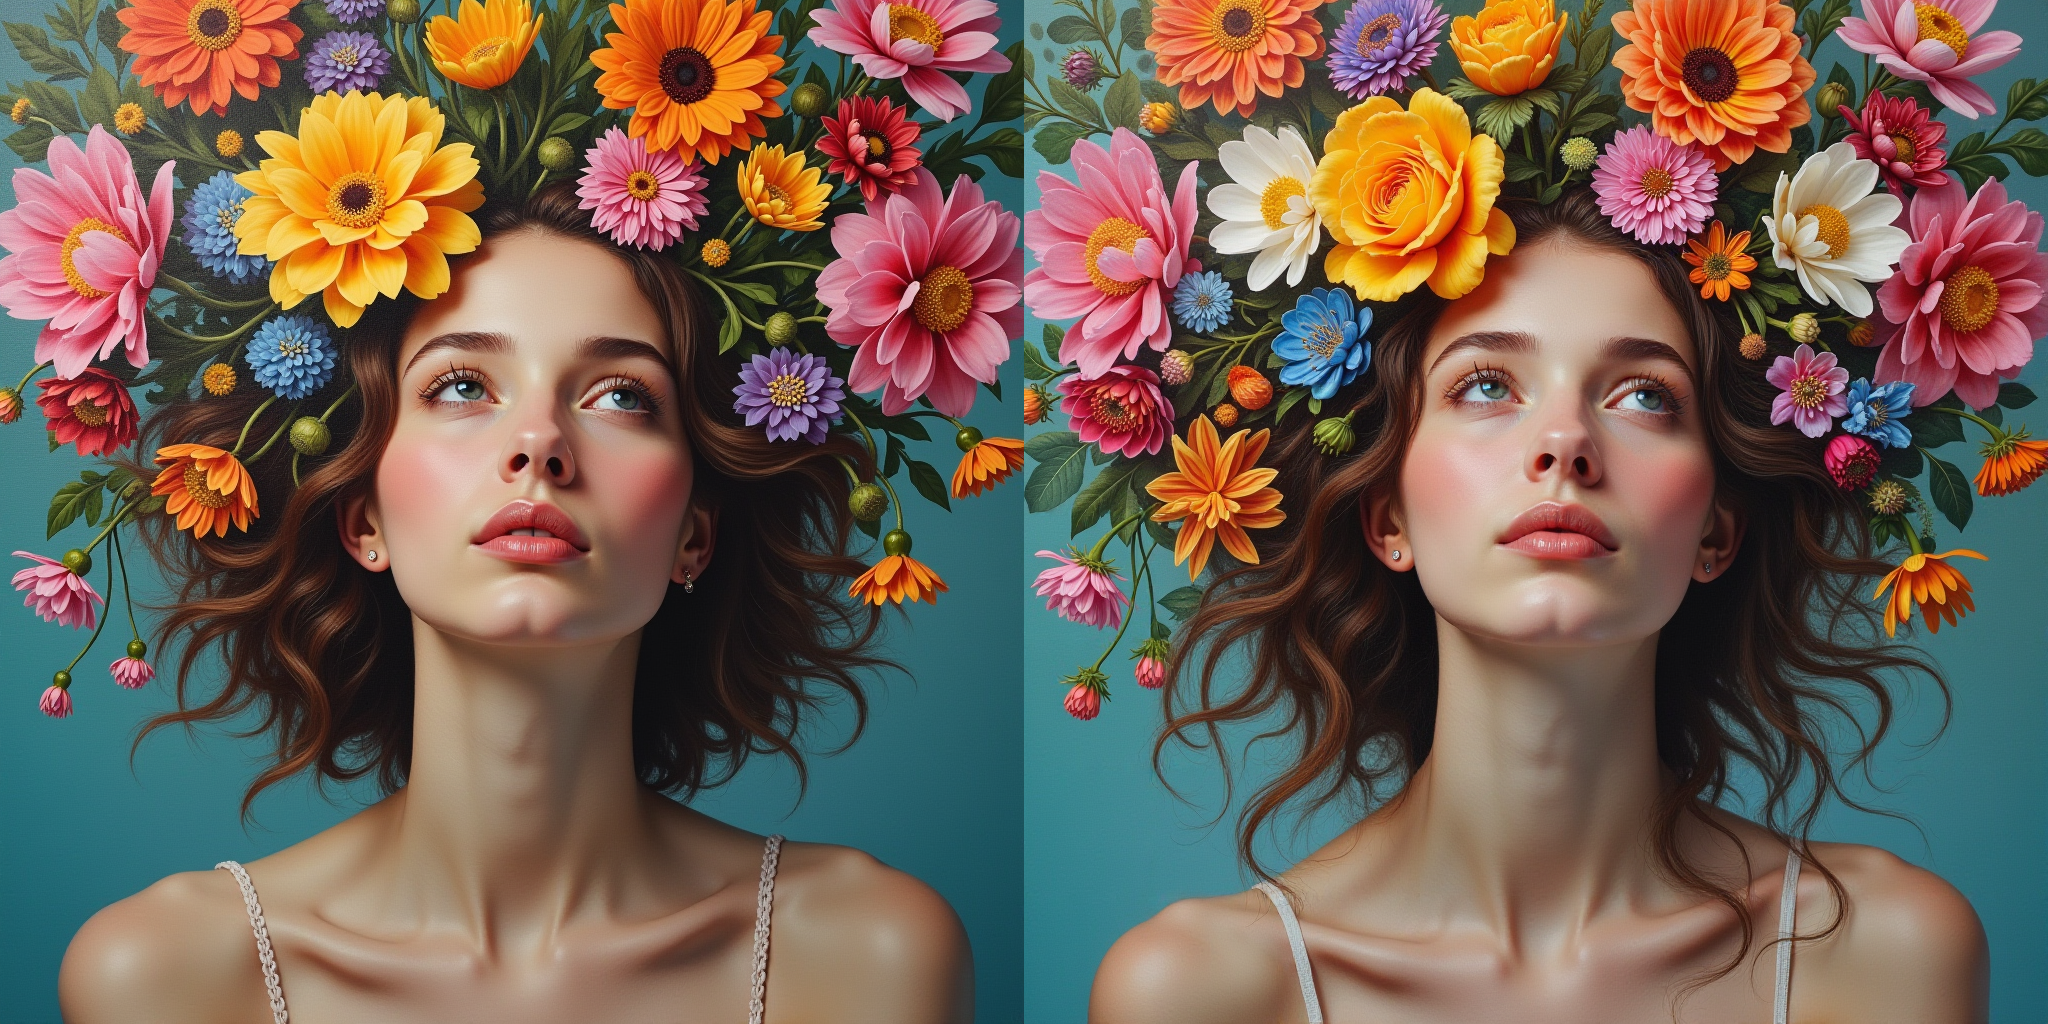

In [12]:
grid = Image.new('RGB', (2 * 1024, 1 * 1024))
grid.paste(img_orig[0], (0 * 1024, 0 * 1024))
grid.paste(img_pisa[0], (1 * 1024, 0 * 1024))
grid